In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
from skimage import io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.utils import class_weight
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
 
import warnings
warnings.simplefilter("ignore")

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Download Data using Kaggle API

https://www.kaggle.com/docs/api

https://www.kaggle.com/general/74235

## Coco Dataset

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle                 #make directory(folder) named .kaggle
 
! cp /content/drive/MyDrive/Datasets/kaggle.json ~/.kaggle/       #copy file to folder
 
! chmod 600 ~/.kaggle/kaggle.json        #Change the permissions of the file.

In [ ]:
! kaggle datasets download oishee30/cocopersonsegmentation

print(os.listdir('/content'))

100% 8.20G/8.20G [03:22<00:00, 57.4MB/s]
100% 8.20G/8.20G [03:22<00:00, 43.4MB/s]
['.config', 'cocopersonsegmentation.zip', 'drive', 'sample_data']


In [ ]:
start = datetime.now()
! mkdir data        #making directory data
 
! unzip cocopersonsegmentation.zip -d data           #unzipping data into data directory 
 
end = datetime.now()
print("time taken to unzip:",end -start)

In [ ]:
os.remove('cocopersonsegmentation.zip')
print(os.listdir('/content'))


['.config', 'drive', 'data', 'sample_data']


In [ ]:
os.listdir('/content/data')

['val2017_ann', 'train2017_new', 'codes.txt', 'train2017_ann', 'val2017_new']

In [ ]:
path = '/content/data'
for folder in os.listdir(path):
  if '.txt' not in folder:
    print('No of images in',folder,len(os.listdir(path+'/'+folder)))

No of images in val2017_ann 2693
No of images in train2017_new 64115
No of images in train2017_ann 64115
No of images in val2017_new 2693


# Prepare Datset for training



In [ ]:
xpath_coco = '/content/data/train2017_new/'
ypath_coco = '/content/data/train2017_ann/'
x_test_path = '/content/data/val2017_new/'
y_test_path = '/content/data/val2017_ann/'

In [ ]:
input_img_paths_coco = sorted([os.path.join(xpath_coco, fname) for fname in os.listdir(xpath_coco)])
target_img_paths_coco = sorted([os.path.join(ypath_coco, fname) for fname in os.listdir(ypath_coco)])

print(len(input_img_paths_coco), len(target_img_paths_coco))
for input_path, target_path in zip(input_img_paths_coco[:4], target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

64115 64115
/content/data/train2017_new/000000000036.jpg | /content/data/train2017_ann/000000000036.jpg
/content/data/train2017_new/000000000049.jpg | /content/data/train2017_ann/000000000049.jpg
/content/data/train2017_new/000000000061.jpg | /content/data/train2017_ann/000000000061.jpg
/content/data/train2017_new/000000000074.jpg | /content/data/train2017_ann/000000000074.jpg


In [ ]:
test_input_img_paths_coco = sorted([os.path.join(x_test_path, fname) for fname in os.listdir(x_test_path)])
test_target_img_paths_coco = sorted([os.path.join(y_test_path, fname) for fname in os.listdir(y_test_path)])

print(len(test_input_img_paths_coco), len(test_target_img_paths_coco))
for input_path, target_path in zip(test_input_img_paths_coco[:4], test_target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

2693 2693
/content/data/val2017_new/000000000139.jpg | /content/data/val2017_ann/000000000139.jpg
/content/data/val2017_new/000000000785.jpg | /content/data/val2017_ann/000000000785.jpg
/content/data/val2017_new/000000000872.jpg | /content/data/val2017_ann/000000000872.jpg
/content/data/val2017_new/000000000885.jpg | /content/data/val2017_ann/000000000885.jpg


In [ ]:
train_input_img_paths = input_img_paths_coco.copy()
train_target_img_paths = target_img_paths_coco.copy()

val_input_img_paths = test_input_img_paths_coco.copy()
val_target_img_paths = test_target_img_paths_coco.copy()

print(len(train_input_img_paths), len(train_target_img_paths))
print(len(val_input_img_paths), len(val_target_img_paths))

64115 64115
2693 2693


In [ ]:
samples = 500

train_input_img_paths = train_input_img_paths[:samples]
train_target_img_paths = train_target_img_paths[:samples]

val_input_img_paths = val_input_img_paths[:250]
val_target_img_paths = val_target_img_paths[:250]

In [ ]:
#shuffle image paths
import random
random.seed(0)

ziped_list = list(zip(train_input_img_paths, train_target_img_paths))

random.shuffle(ziped_list)                          #shuffle, it will shuffle the list and return none.

ziped_list[:4]

[('/content/data/train2017_new/000000004187.jpg',
  '/content/data/train2017_ann/000000004187.jpg'),
 ('/content/data/train2017_new/000000004535.jpg',
  '/content/data/train2017_ann/000000004535.jpg'),
 ('/content/data/train2017_new/000000001307.jpg',
  '/content/data/train2017_ann/000000001307.jpg'),
 ('/content/data/train2017_new/000000004286.jpg',
  '/content/data/train2017_ann/000000004286.jpg')]

In [ ]:
unziped_list = list(zip(*ziped_list))
len(unziped_list)

2

In [ ]:
train_input_img_paths = unziped_list[0]
train_target_img_paths = unziped_list[1]

print("Number of training samples input:", len(train_input_img_paths))
print("Number of training samples labels:", len(train_target_img_paths))

for input_path, target_path in zip(train_input_img_paths[:4], train_target_img_paths[:4]):
    print(input_path, "|", target_path)

Number of training samples input: 500
Number of training samples labels: 500
/content/data/train2017_new/000000004187.jpg | /content/data/train2017_ann/000000004187.jpg
/content/data/train2017_new/000000004535.jpg | /content/data/train2017_ann/000000004535.jpg
/content/data/train2017_new/000000001307.jpg | /content/data/train2017_ann/000000001307.jpg
/content/data/train2017_new/000000004286.jpg | /content/data/train2017_ann/000000004286.jpg


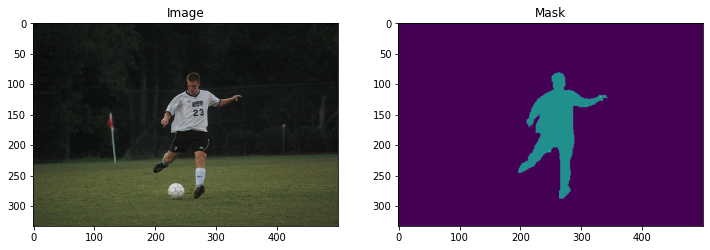

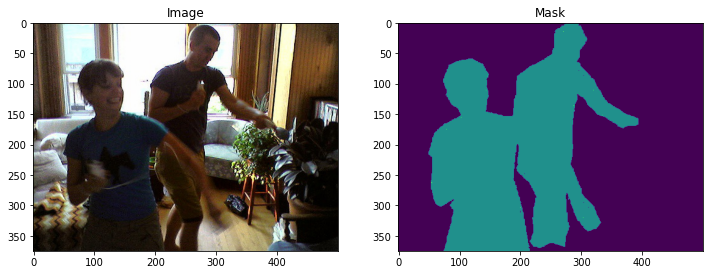

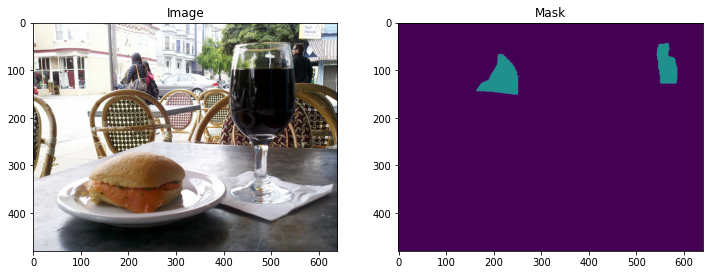

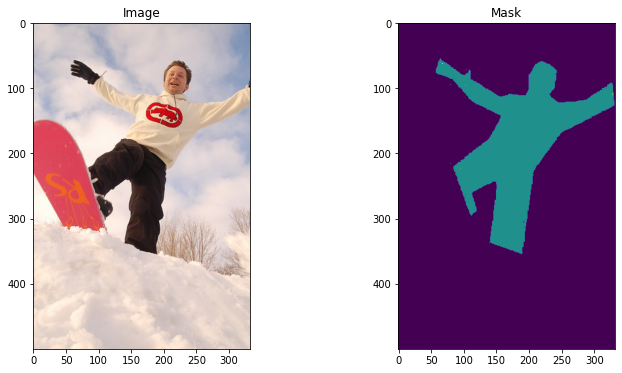

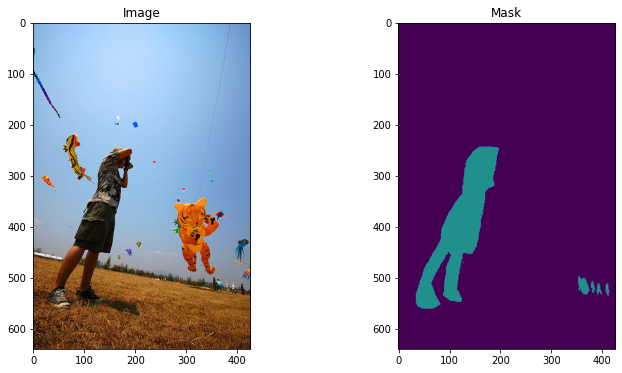

In [ ]:
n_images = 5
for i in np.random.randint(0,len(train_input_img_paths),n_images):
 
  fig = plt.figure(figsize=(12,6))
  fig.tight_layout()
 
  plt.subplot(1,2,1)
  img = plt.imread(train_input_img_paths[i])
  plt.imshow(img)
  plt.title('Image')
 
  plt.subplot(1,2,2)
  img = plt.imread(train_target_img_paths[i])
  plt.imshow(img)
  plt.title('Mask')
 
  plt.show()
  print()

(array([0, 1, 2], dtype=uint8), array([177314,  95931,     35]))
(427, 640)


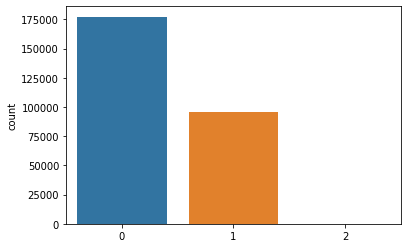

In [ ]:
mask = plt.imread(train_target_img_paths[0])
print(np.unique(mask, return_counts= True))
print(mask.shape)
sns.countplot(mask.ravel())
plt.show()

# Data Generator

In [ ]:
class Data_Generator(keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
 
    def __len__(self):
        """
        Returns number of batches.
        """
        return len(self.target_img_paths) // self.batch_size                    # 64115//32
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to batch #index.
        """

        iterator = index * self.batch_size                                                            # 0
        batch_input_img_paths = self.input_img_paths[iterator : iterator + self.batch_size]                # [0: 0+32]
        batch_target_img_paths = self.target_img_paths[iterator : iterator + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)/255
            x[j] = img
 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2)                                                  #(256,256,1)
 
        return x, y

In [ ]:
# Gererator function
batch_size = 32
img_size = (256,256)
 
train_gen = Data_Generator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Data_Generator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
print(train_gen.__len__())
print(val_gen.__len__())

15
7


In [ ]:
#x, y = train_gen.__getitem__(0)
#print(x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


In [ ]:
#print(y[0].shape)
#print(np.unique(y[0], return_counts= True))

(256, 256, 1)
(array([0, 1], dtype=uint8), array([42524, 23012]))


# Model 1

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)

  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
 
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)
 
  return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)

  if dropout:
    x = layers.Dropout(0.2)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation
 
  x = layers.BatchNormalization()(concat)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  if dropout:
    x = layers.Dropout(0.2)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
   
  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addition
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)
 
  return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))

layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
 
conv1, pool1 = downblock(32, 3, layer1, dropout = False)
conv2, pool2 = downblock(64, 3, pool1, dropout = False)
conv3, pool3 = downblock(128, 3, pool2, dropout = False)
conv4, pool4 = downblock(256, 3, pool3, dropout = False)
 
conv5 = bottleneck(512,3,pool4, dropout = False)

upconv1 = upblock(256, 3, conv5, conv4, dropout = False) 
upconv2 = upblock(128, 3, upconv1, conv3, dropout = False)
upconv3 = upblock(64, 3, upconv2, conv2, dropout = False)
upconv4 = upblock(32, 3, upconv3, conv1, dropout = False)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model1 = keras.Model(input_layer, output_layer)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#33img_file = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/Deep_Model.png"
#tf.keras.utils.plot_model(model, to_file= img_file, show_shapes=True, show_layer_names=True)

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
a = np.array([0, 1, 1, 0])
b = np.array([1, 0.3, .19, 0.8])
 
mean_iou(a,b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam()      #learning_rate=0.001
 
model1.compile(optimizer=opt,
              loss="binary_crossentropy", 
              metrics=['accuracy', mean_iou])  
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/model_wto_lastlayer_act_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history1 = model1.fit(train_gen,
                          epochs = epochs,
                          validation_data = val_gen)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 0.4519 - accuracy: 0.8242 - mean_iou: 0.4136 - val_loss: 0.5906 - val_accuracy: 0.8217 - val_mean_iou: 0.4165
Epoch 2/50
15/15 [==============================] - 15s 1s/step - loss: 0.3956 - accuracy: 0.8361 - mean_iou: 0.4178 - val_loss: 0.4769 - val_accuracy: 0.8216 - val_mean_iou: 0.4188
Epoch 3/50
15/15 [==============================] - 15s 1s/step - loss: 0.3650 - accuracy: 0.8386 - mean_iou: 0.4244 - val_loss: 0.4718 - val_accuracy: 0.7510 - val_mean_iou: 0.4402
Epoch 4/50
15/15 [==============================] - 15s 1s/step - loss: 0.3560 - accuracy: 0.8399 - mean_iou: 0.4474 - val_loss: 0.4994 - val_accuracy: 0.8222 - val_mean_iou: 0.4481
Epoch 5/50
15/15 [==============================] - 15s 1s/step - loss: 0.3406 - accuracy: 0.8431 - mean_iou: 0.4528 - val_loss: 0.6386 - val_accuracy: 0.8216 - val_mean_iou: 0.4564
Epoch 6/50
15/15 [==============================] - 15s 1s/step - loss: 0.3241 - accuracy:

In [ ]:
history1 = model_history1.history 
len(history1)

6

In [ ]:
'''
First model
history = {'loss': [0.2582,0.1537,0.1354],
           'accuracy': [0.8925,0.9363,0.9443],
           'mean_io_u': [0.4290,0.4291,0.4288],
           'val_loss': [0.2502,0.2566,0.2920],
           'val_accuracy': [0.8997,0.9046,0.9030],
           'val_mean_io_u': [0.4162,0.4162,0.4162]
}
'''

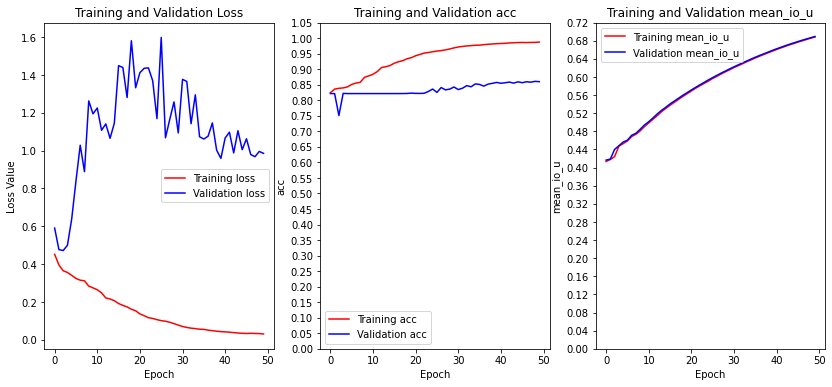

In [ ]:
train_loss = history1['loss']
val_loss = history1['val_loss']
train_acc = history1['accuracy']
val_acc = history1['val_accuracy']
train_iou = history1['mean_iou']
val_iou = history1['val_mean_iou']

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.yticks(np.arange(0, 1.1, .05))
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0, 1.1, .05))
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_io_u')
plt.plot(val_iou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u')
plt.yticks(np.arange(0, .76, .04))
plt.legend()
plt.show()

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model1_results.json', 'w') as fp:
    json.dump(history1, fp)

In [ ]:
history1

# Clear session

In [ ]:
tf.keras.backend.clear_session()

# Model 2

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
    x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.Activation("relu")(x)
    p = layers.MaxPooling2D(2)(x)

    return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
    x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
    x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
    concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation

    x = layers.Conv2D(filters, filter_size, padding="same")(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.Activation("relu")(x)

    return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))

layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
 
conv1, pool1 = downblock(32, 3, layer1, dropout = False)
conv2, pool2 = downblock(64, 3, pool1, dropout = False)
conv3, pool3 = downblock(128, 3, pool2, dropout = False)
conv4, pool4 = downblock(256, 3, pool3, dropout = False)
 
conv5 = bottleneck(512,3,pool4, dropout = False)

upconv1 = upblock(256, 3, conv5, conv4, dropout = False) 
upconv2 = upblock(128, 3, upconv1, conv3, dropout = False)
upconv3 = upblock(64, 3, upconv2, conv2, dropout = False)
upconv4 = upblock(32, 3, upconv3, conv1, dropout = False)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model2 = keras.Model(input_layer, output_layer)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
#33img_file = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/Deep_Model.png"
#tf.keras.utils.plot_model(model, to_file= img_file, show_shapes=True, show_layer_names=True)

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
a = np.array([0, 1, 1, 0])
b = np.array([1, 0.3, .19, 0.8])
 
mean_iou(a,b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam()      #learning_rate=0.001
 
model2.compile(optimizer=opt,
              loss="binary_crossentropy", 
              metrics=['accuracy', mean_iou])  
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/model_wto_lastlayer_act_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history2 = model2.fit(train_gen,
                          epochs = epochs,
                          validation_data = val_gen)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 0.5648 - accuracy: 0.7335 - mean_iou: 0.3215 - val_loss: 3.6372 - val_accuracy: 0.3536 - val_mean_iou: 0.3796
Epoch 2/50
15/15 [==============================] - 15s 995ms/step - loss: 0.4133 - accuracy: 0.8355 - mean_iou: 0.3838 - val_loss: 5.8299 - val_accuracy: 0.6167 - val_mean_iou: 0.3943
Epoch 3/50
15/15 [==============================] - 15s 983ms/step - loss: 0.3858 - accuracy: 0.8342 - mean_iou: 0.4007 - val_loss: 2.5482 - val_accuracy: 0.7241 - val_mean_iou: 0.4060
Epoch 4/50
15/15 [==============================] - 15s 983ms/step - loss: 0.3778 - accuracy: 0.8340 - mean_iou: 0.4098 - val_loss: 1.0648 - val_accuracy: 0.6090 - val_mean_iou: 0.4121
Epoch 5/50
15/15 [==============================] - 15s 977ms/step - loss: 0.3640 - accuracy: 0.8358 - mean_iou: 0.4149 - val_loss: 0.6226 - val_accuracy: 0.7252 - val_mean_iou: 0.4172
Epoch 6/50
15/15 [==============================] - 15s 986ms/step - loss: 0.3

In [ ]:
history2 = model_history2.history 
len(history2)

6

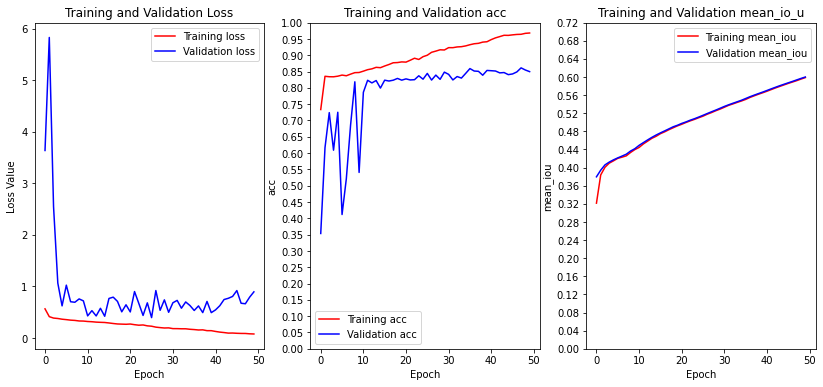

In [ ]:
train_loss = history2['loss']
val_loss = history2['val_loss']
train_acc = history2['accuracy']
val_acc = history2['val_accuracy']
train_iou = history2['mean_iou']
val_iou = history2['val_mean_iou']

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.yticks(np.arange(0, 1.1,.05))
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0, 1.05, .05))
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_iou')
plt.plot(val_iou, 'b', label='Validation mean_iou')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_iou')
plt.yticks(np.arange(0, .76, .04))
plt.legend()
plt.show()

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model2_results.json', 'w') as fp:
    json.dump(history2, fp)
    

In [ ]:
f = open('/content/model2_results123.json')
json.load(f)

{'accuracy': [0.7335469722747803,
  0.8355281352996826,
  0.8341540098190308,
  0.8339684009552002,
  0.8358345627784729,
  0.8392172455787659,
  0.8371278047561646,
  0.8421244025230408,
  0.8466429114341736,
  0.8471460938453674,
  0.8512722253799438,
  0.8557701110839844,
  0.8583325743675232,
  0.8629776835441589,
  0.8618852496147156,
  0.8670690655708313,
  0.8716504573822021,
  0.8769698739051819,
  0.877597451210022,
  0.8796108365058899,
  0.8789549469947815,
  0.884719967842102,
  0.8908942937850952,
  0.8871238231658936,
  0.8956214785575867,
  0.9001228213310242,
  0.9090651273727417,
  0.9127064347267151,
  0.9167752861976624,
  0.9161458611488342,
  0.9233213067054749,
  0.9232503175735474,
  0.9254847168922424,
  0.9262867569923401,
  0.9286759495735168,
  0.9323031306266785,
  0.9352700710296631,
  0.9365655779838562,
  0.9402962923049927,
  0.9414607882499695,
  0.9480178952217102,
  0.9533234238624573,
  0.957224428653717,
  0.9612348079681396,
  0.9609385132789612,
 

# Clear session

In [ ]:
tf.keras.backend.clear_session()

# Model 3 - Model 1 with dropout

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
 
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)
 
  return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation
 
  x = layers.BatchNormalization()(concat)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
   
  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addition
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)
 
  return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))
 
layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
 
conv1, pool1 = downblock(32, 3, layer1, dropout = True)
conv2, pool2 = downblock(64, 3, pool1, dropout = True)
conv3, pool3 = downblock(128, 3, pool2, dropout = True)
conv4, pool4 = downblock(256, 3, pool3, dropout = True)
 
conv5 = bottleneck(512,3,pool4, dropout = True)
 
upconv1 = upblock(256, 3, conv5, conv4, dropout = True) 
upconv2 = upblock(128, 3, upconv1, conv3, dropout = True)
upconv3 = upblock(64, 3, upconv2, conv2, dropout = True)
upconv4 = upblock(32, 3, upconv3, conv1, dropout = True)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model3 = keras.Model(input_layer, output_layer)
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#33img_file = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/Deep_Model.png"
#tf.keras.utils.plot_model(model, to_file= img_file, show_shapes=True, show_layer_names=True)

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
a = np.array([0, 1, 1, 0])
b = np.array([1, 0.3, .19, 0.8])
 
mean_iou(a,b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam()      #learning_rate=0.001
 
model3.compile(optimizer=opt,
              loss="binary_crossentropy", 
              metrics=['accuracy', mean_iou])  
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/model_wto_lastlayer_act_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history3 = model3.fit(train_gen,
                          epochs = epochs,
                          validation_data = val_gen)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/50
15/15 [==============================] - 82s 2s/step - loss: 0.4484 - accuracy: 0.8297 - mean_iou: 0.4304 - val_loss: 0.5434 - val_accuracy: 0.8216 - val_mean_iou: 0.4216
Epoch 2/50
15/15 [==============================] - 34s 2s/step - loss: 0.4033 - accuracy: 0.8341 - mean_iou: 0.4222 - val_loss: 0.4943 - val_accuracy: 0.8216 - val_mean_iou: 0.4218
Epoch 3/50
15/15 [==============================] - 34s 2s/step - loss: 0.3745 - accuracy: 0.8374 - mean_iou: 0.4243 - val_loss: 0.4606 - val_accuracy: 0.8216 - val_mean_iou: 0.4284
Epoch 4/50
15/15 [==============================] - 34s 2s/step - loss: 0.3660 - accuracy: 0.8330 - mean_iou: 0.4334 - val_loss: 0.6276 - val_accuracy: 0.8216 - val_mean_iou: 0.4335
Epoch 5/50
15/15 [==============================] - 34s 2s/step - loss: 0.3436 - accuracy: 0.8434 - mean_iou: 0.4374 - val_loss: 0.7525 - val_accuracy: 0.8216 - val_mean_iou: 0.4413
Epoch 6/50
15/15 [==============================] - 34s 2s/step - loss: 0.3318 - accuracy:

In [ ]:
history3 = model_history3.history 
len(history3)

6

In [ ]:
'''
First model
history = {'loss': [0.2582,0.1537,0.1354],
           'accuracy': [0.8925,0.9363,0.9443],
           'mean_io_u': [0.4290,0.4291,0.4288],
           'val_loss': [0.2502,0.2566,0.2920],
           'val_accuracy': [0.8997,0.9046,0.9030],
           'val_mean_io_u': [0.4162,0.4162,0.4162]
}
'''

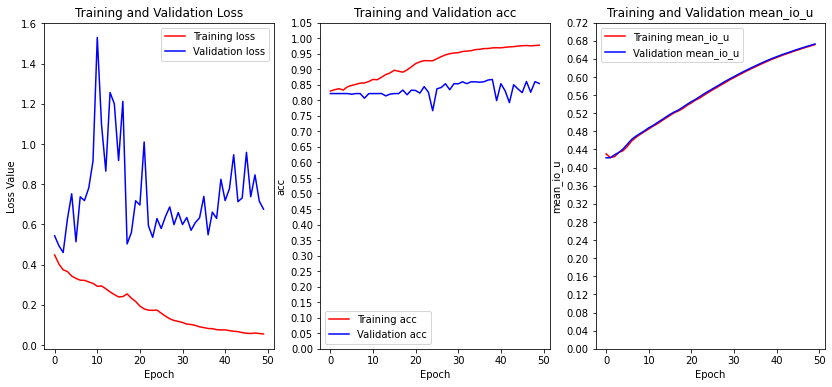

In [ ]:
train_loss = history3['loss']
val_loss = history3['val_loss']
train_acc = history3['accuracy']
val_acc = history3['val_accuracy']
train_iou = history3['mean_iou']
val_iou = history3['val_mean_iou']
 
plt.figure(figsize=(14,6))
 
plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.yticks(np.arange(0, 1.1, .05))
plt.legend()
 
plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0, 1.1, .05))
plt.legend()
 
plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_io_u')
plt.plot(val_iou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u')
plt.yticks(np.arange(0, .76, .04))
plt.legend()
plt.show()

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model3_results.json', 'w') as fp:
    json.dump(history3, fp)

# Clear session

In [ ]:
tf.keras.backend.clear_session()

# Model 4 - Model 2 with dropout

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
    x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.Activation("relu")(x)
    p = layers.MaxPooling2D(2)(x)

    return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
    x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
    x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
    concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation

    x = layers.Conv2D(filters, filter_size, padding="same")(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters, filter_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addintion
    x = layers.add([x, residual])  # Add back residual

    x = layers.Activation("relu")(x)

    return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))

layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
 
conv1, pool1 = downblock(32, 3, layer1, dropout = True)
conv2, pool2 = downblock(64, 3, pool1, dropout = True)
conv3, pool3 = downblock(128, 3, pool2, dropout = True)
conv4, pool4 = downblock(256, 3, pool3, dropout = True)
 
conv5 = bottleneck(512,3,pool4, dropout = True)

upconv1 = upblock(256, 3, conv5, conv4, dropout = True) 
upconv2 = upblock(128, 3, upconv1, conv3, dropout = True)
upconv3 = upblock(64, 3, upconv2, conv2, dropout = True)
upconv4 = upblock(32, 3, upconv3, conv1, dropout = True)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model4 = keras.Model(input_layer, output_layer)
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
#33img_file = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/Deep_Model.png"
#tf.keras.utils.plot_model(model, to_file= img_file, show_shapes=True, show_layer_names=True)

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
a = np.array([0, 1, 1, 0])
b = np.array([1, 0.3, .19, 0.8])
 
mean_iou(a,b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam()      #learning_rate=0.001
 
model4.compile(optimizer=opt,
              loss="binary_crossentropy", 
              metrics=['accuracy', mean_iou])  
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/model_wto_lastlayer_act_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history4 = model4.fit(train_gen,
                          epochs = epochs,
                          validation_data = val_gen)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/50
15/15 [==============================] - 42s 3s/step - loss: 0.4902 - accuracy: 0.7892 - mean_iou: 0.3851 - val_loss: 22.9271 - val_accuracy: 0.5461 - val_mean_iou: 0.4101
Epoch 2/50
15/15 [==============================] - 37s 2s/step - loss: 0.4167 - accuracy: 0.8355 - mean_iou: 0.4105 - val_loss: 13.8170 - val_accuracy: 0.4146 - val_mean_iou: 0.4083
Epoch 3/50
15/15 [==============================] - 37s 2s/step - loss: 0.3957 - accuracy: 0.8354 - mean_iou: 0.4070 - val_loss: 1.0561 - val_accuracy: 0.8007 - val_mean_iou: 0.4108
Epoch 4/50
15/15 [==============================] - 37s 2s/step - loss: 0.3823 - accuracy: 0.8344 - mean_iou: 0.4147 - val_loss: 0.4487 - val_accuracy: 0.8217 - val_mean_iou: 0.4168
Epoch 5/50
15/15 [==============================] - 37s 3s/step - loss: 0.3683 - accuracy: 0.8349 - mean_iou: 0.4188 - val_loss: 0.4580 - val_accuracy: 0.8219 - val_mean_iou: 0.4204
Epoch 6/50
15/15 [==============================] - 37s 2s/step - loss: 0.3631 - accurac

In [ ]:
history4 = model_history4.history 
len(history4)

6

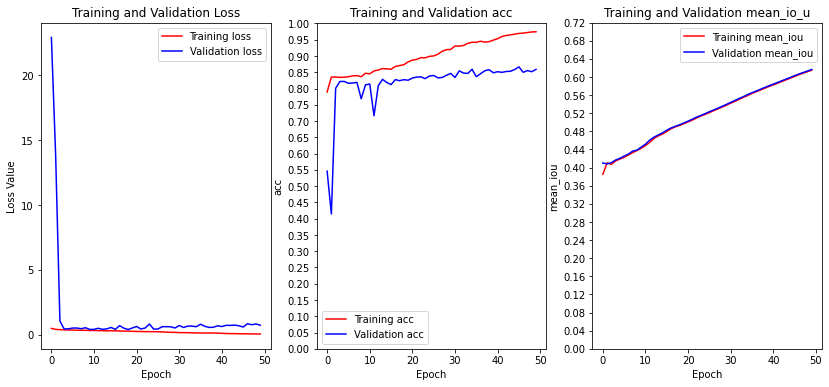

In [ ]:
train_loss = history4['loss']
val_loss = history4['val_loss']
train_acc = history4['accuracy']
val_acc = history4['val_accuracy']
train_iou = history4['mean_iou']
val_iou = history4['val_mean_iou']

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.yticks(np.arange(0, 1.1,.05))
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0, 1.05, .05))
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_iou')
plt.plot(val_iou, 'b', label='Validation mean_iou')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_iou')
plt.yticks(np.arange(0, .76, .04))
plt.legend()
plt.show()

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model4_results.json', 'w') as fp:
    json.dump(history4, fp)
    

# Clear session

In [ ]:
tf.keras.backend.clear_session()

# Model 5 - Model 3 with loss_weights


https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights

In [ ]:
class Data_Generator(keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, class_weights):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.class_weights = tf.constant(class_weights)
        self.class_weights = self.class_weights/tf.reduce_sum(self.class_weights)
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size                    # 64115//32
 
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to batch #index.
        """
        iterator = index * self.batch_size                                                            # 0
        batch_input_img_paths = self.input_img_paths[iterator : iterator + self.batch_size]                # [0: 0+32]
        batch_target_img_paths = self.target_img_paths[iterator : iterator + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)/255
            x[j] = img
 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2)                                                  #(256,256,1)
 
        sample_weights = tf.gather(self.class_weights, indices = tf.cast(y, tf.int32))
 
        return x, y, sample_weights

In [ ]:
# Gererator function
batch_size = 32
img_size = (256,256)
class_weights = [1,1.5]
 
train_gen = Data_Generator(batch_size, img_size, train_input_img_paths, train_target_img_paths, class_weights)
val_gen = Data_Generator(batch_size, img_size, val_input_img_paths, val_target_img_paths, class_weights)

In [ ]:
x, y, sw = train_gen.__getitem__(0)
print(type(sw))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
sw.shape

TensorShape([32, 256, 256, 1])

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
 
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)
 
  return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation
 
  x = layers.BatchNormalization()(concat)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
   
  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addition
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)
 
  return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))
 
layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
 
conv1, pool1 = downblock(32, 3, layer1, dropout = True)
conv2, pool2 = downblock(64, 3, pool1, dropout = True)
conv3, pool3 = downblock(128, 3, pool2, dropout = True)
conv4, pool4 = downblock(256, 3, pool3, dropout = True)
 
conv5 = bottleneck(512,3,pool4, dropout = True)
 
upconv1 = upblock(256, 3, conv5, conv4, dropout = True)
upconv2 = upblock(128, 3, upconv1, conv3, dropout = True)
upconv3 = upblock(64, 3, upconv2, conv2, dropout = True)
upconv4 = upblock(32, 3, upconv3, conv1, dropout = True)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model5 = keras.Model(input_layer, output_layer)
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
 from tensorflow.keras.optimizers import Adam
opt = Adam()      #learning_rate=0.001
 
model5.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy', mean_iou])  
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/model_wto_lastlayer_act_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history5 = model5.fit(train_gen,
                            epochs = epochs,
                            validation_data = val_gen)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/50
15/15 [==============================] - 66s 1s/step - loss: 0.2565 - accuracy: 0.7759 - mean_iou: 0.3621 - val_loss: 0.2682 - val_accuracy: 0.8216 - val_mean_iou: 0.4102
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 0.2183 - accuracy: 0.8358 - mean_iou: 0.4145 - val_loss: 0.2543 - val_accuracy: 0.8216 - val_mean_iou: 0.4147
Epoch 3/50
15/15 [==============================] - 17s 1s/step - loss: 0.2143 - accuracy: 0.8357 - mean_iou: 0.4165 - val_loss: 0.2441 - val_accuracy: 0.8216 - val_mean_iou: 0.4154
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.2092 - accuracy: 0.8351 - mean_iou: 0.4163 - val_loss: 0.2483 - val_accuracy: 0.8216 - val_mean_iou: 0.4159
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.2028 - accuracy: 0.8281 - mean_iou: 0.4183 - val_loss: 0.2367 - val_accuracy: 0.8202 - val_mean_iou: 0.4206
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.1937 - accuracy:

In [ ]:
history5 = model_history5.history 
len(history5)

6

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model5_results.json', 'w') as fp:
    json.dump(history5, fp)

In [ ]:
 def plot_result(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_iou = history['mean_iou']
    val_iou = history['val_mean_iou']
 
    plt.figure(figsize=(16,6))
 
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r', label='Training loss')
    plt.plot(val_loss, 'b', label='Validation loss')
    plt.text(len(train_loss)-4, train_loss[-1]-0.05, str(round(train_loss[-1], 3)), color = 'black')
    plt.text(len(val_loss)-4, val_loss[-1]-0.05, str(round(val_loss[-1], 3)), color = 'black')
 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    #plt.yticks(np.arange(0, 1.1,.05))
    plt.legend()
 
    plt.subplot(1,3,2)
    plt.plot(train_acc, 'r', label='Training acc')
    plt.plot(val_acc, 'b', label='Validation acc')
    plt.text(len(train_acc)-4, train_acc[-1]-0.04, str(round(train_acc[-1], 3)), color = 'black')
    plt.text(len(val_acc)-4, val_acc[-1]-.04, str(round(val_acc[-1], 3)), color = 'black')
 
    plt.title('Training and Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.yticks(np.arange(0, 1.05, .05))
    plt.legend()
 
    plt.subplot(1,3,3)
    plt.plot(train_iou, 'r', label='Training mean_iou')
    plt.plot(val_iou, 'b', label='Validation mean_iou')
    plt.text(len(train_iou)-4, train_iou[-1]-.05, str(round(train_iou[-1], 3)), color = 'black')
    plt.text(len(val_iou)-4, val_iou[-1]-.05, str(round(val_iou[-1], 3)), color = 'black')
 
    plt.title('Training and Validation mean_io_u')
    plt.xlabel('Epoch')
    plt.ylabel('mean_iou')
    plt.yticks(np.arange(0, .8, .04))
    plt.legend()
    plt.show()

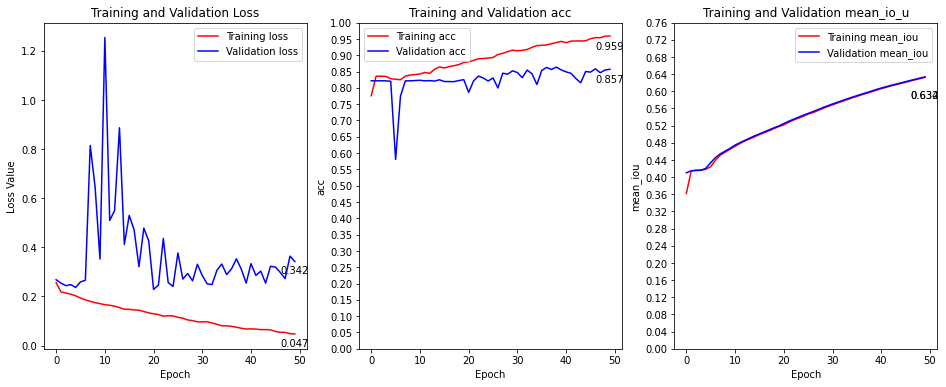

In [ ]:
plot_result(history5)

In [ ]:
Class_weight = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y.ravel()),
                                                  y.ravel())
Class_weight

array([0.5930853 , 3.18570864])

In [ ]:
Class_weight/np.sum(Class_weight)

array([0.15695095, 0.84304905])

# Clear session

In [ ]:
tf.keras.backend.clear_session()

# Model 6 - Model 3 with individual batch class weights

In [ ]:
class Data_Generator(keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
       
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size                    # 64115//32
 
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to batch #index.
        """

        iterator = index * self.batch_size                                                            # 0
        batch_input_img_paths = self.input_img_paths[iterator : iterator + self.batch_size]                # [0: 0+32]
        batch_target_img_paths = self.target_img_paths[iterator : iterator + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)/255
            x[j] = img
 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2)                                                  #(256,256,1)
 
        class_weights = class_weight.compute_class_weight('balanced', np.unique(y.ravel()),  y.ravel())
        class_weights = class_weights/np.sum(class_weights)
        sample_weights = tf.gather(class_weights, indices = tf.cast(y, tf.int32))
 
        return x, y, sample_weights

In [ ]:
# Gererator function
batch_size = 32
img_size = (256,256)
 
train_gen = Data_Generator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Data_Generator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
x, y, sw = train_gen.__getitem__(0)
print(type(sw))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
sw.shape

TensorShape([32, 256, 256, 1])

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
 
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)
 
  return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation
 
  x = layers.BatchNormalization()(concat)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
   
  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addition
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)
 
  return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))
 
layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
 
conv1, pool1 = downblock(32, 3, layer1, dropout = True)
conv2, pool2 = downblock(64, 3, pool1, dropout = True)
conv3, pool3 = downblock(128, 3, pool2, dropout = True)
conv4, pool4 = downblock(256, 3, pool3, dropout = True)
 
conv5 = bottleneck(512,3,pool4, dropout = True)
 
upconv1 = upblock(256, 3, conv5, conv4, dropout = True)
upconv2 = upblock(128, 3, upconv1, conv3, dropout = True)
upconv3 = upblock(64, 3, upconv2, conv2, dropout = True)
upconv4 = upblock(32, 3, upconv3, conv1, dropout = True)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
model6 = keras.Model(input_layer, output_layer)
model6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam()      #learning_rate=0.001
 
model6.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=['accuracy', mean_iou])  
 
filepath = "/content/drive/MyDrive/Colab_Notebooks/Background_Remover/Deep_Model/model_wto_lastlayer_act_epoch_{epoch:00d}_val_loss_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 50
model_history6 = model6.fit(train_gen,
                            epochs = epochs,
                            validation_data = val_gen)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

Epoch 1/50
15/15 [==============================] - 87s 3s/step - loss: 0.1796 - accuracy: 0.6029 - mean_iou: 0.3734 - val_loss: 0.1980 - val_accuracy: 0.8152 - val_mean_iou: 0.4029
Epoch 2/50
15/15 [==============================] - 37s 2s/step - loss: 0.1560 - accuracy: 0.6571 - mean_iou: 0.4227 - val_loss: 0.2031 - val_accuracy: 0.8096 - val_mean_iou: 0.4324
Epoch 3/50
15/15 [==============================] - 37s 2s/step - loss: 0.1449 - accuracy: 0.6860 - mean_iou: 0.4398 - val_loss: 0.2432 - val_accuracy: 0.8216 - val_mean_iou: 0.4472
Epoch 4/50
15/15 [==============================] - 38s 2s/step - loss: 0.1393 - accuracy: 0.7075 - mean_iou: 0.4530 - val_loss: 0.3064 - val_accuracy: 0.8216 - val_mean_iou: 0.4579
Epoch 5/50
15/15 [==============================] - 37s 2s/step - loss: 0.1306 - accuracy: 0.7106 - mean_iou: 0.4627 - val_loss: 0.3634 - val_accuracy: 0.8216 - val_mean_iou: 0.4656
Epoch 6/50
15/15 [==============================] - 38s 2s/step - loss: 0.1250 - accuracy:

In [ ]:
history6 = model_history6.history 
len(history6)

6

In [ ]:
def plot_result(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_iou = history['mean_iou']
    val_iou = history['val_mean_iou']
 
    plt.figure(figsize=(16,6))
 
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r', label='Training loss')
    plt.plot(val_loss, 'b', label='Validation loss')
    plt.text(len(train_loss)-4, train_loss[-1]-0.05, str(round(train_loss[-1], 3)), color = 'black')
    plt.text(len(val_loss)-4, val_loss[-1]-0.05, str(round(val_loss[-1], 3)), color = 'black')
 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    #plt.yticks(np.arange(0, 1.1,.05))
    plt.legend()
 
    plt.subplot(1,3,2)
    plt.plot(train_acc, 'r', label='Training acc')
    plt.plot(val_acc, 'b', label='Validation acc')
    plt.text(len(train_acc)-4, train_acc[-1]-0.04, str(round(train_acc[-1], 3)), color = 'black')
    plt.text(len(val_acc)-4, val_acc[-1]-.04, str(round(val_acc[-1], 3)), color = 'black')
 
    plt.title('Training and Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.yticks(np.arange(0, 1.05, .05))
    plt.legend()
 
    plt.subplot(1,3,3)
    plt.plot(train_iou, 'r', label='Training mean_iou')
    plt.plot(val_iou, 'b', label='Validation mean_iou')
    plt.text(len(train_iou)-4, train_iou[-1]-.05, str(round(train_iou[-1], 3)), color = 'black')
    plt.text(len(val_iou)-4, val_iou[-1]-.05, str(round(val_iou[-1], 3)), color = 'black')
 
    plt.title('Training and Validation mean_io_u')
    plt.xlabel('Epoch')
    plt.ylabel('mean_iou')
    plt.yticks(np.arange(0, .8, .04))
    plt.legend()
    plt.show()

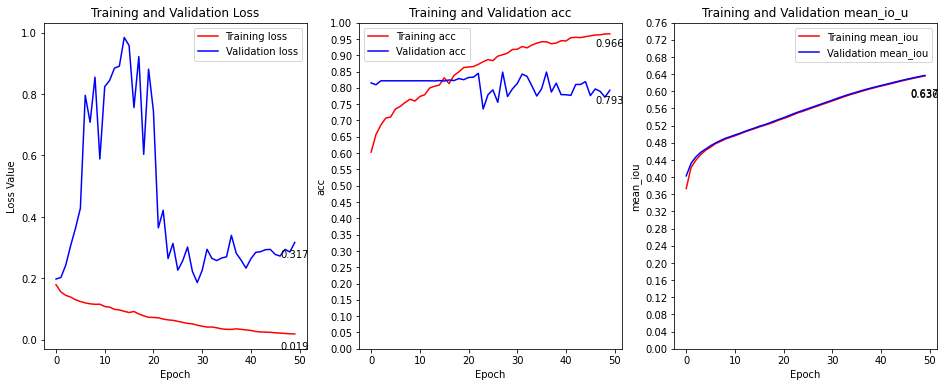

In [ ]:
plot_result(history6)

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_results.json', 'w') as fp:
    json.dump(history6, fp)

# Compare Results

In [ ]:
def plot_result(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_iou = history['mean_iou']
    val_iou = history['val_mean_iou']
 
    plt.figure(figsize=(16,6))
 
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r', label='Training loss')
    plt.plot(val_loss, 'b', label='Validation loss')
    plt.text(len(train_loss)-4, train_loss[-1]-0.05, str(round(train_loss[-1], 3)), color = 'black')
    plt.text(len(val_loss)-4, val_loss[-1]-0.05, str(round(val_loss[-1], 3)), color = 'black')
 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    #plt.yticks(np.arange(0, 1.1,.05))
    plt.legend()
 
    plt.subplot(1,3,2)
    plt.plot(train_acc, 'r', label='Training acc')
    plt.plot(val_acc, 'b', label='Validation acc')
    plt.text(len(train_acc)-4, train_acc[-1]-0.04, str(round(train_acc[-1], 3)), color = 'black')
    plt.text(len(val_acc)-4, val_acc[-1]-.04, str(round(val_acc[-1], 3)), color = 'black')
 
    plt.title('Training and Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.yticks(np.arange(0, 1.05, .05))
    plt.legend()
 
    plt.subplot(1,3,3)
    plt.plot(train_iou, 'r', label='Training mean_iou')
    plt.plot(val_iou, 'b', label='Validation mean_iou')
    plt.text(len(train_iou)-4, train_iou[-1]-.05, str(round(train_iou[-1], 3)), color = 'black')
    plt.text(len(val_iou)-4, val_iou[-1]-.05, str(round(val_iou[-1], 3)), color = 'black')
 
    plt.title('Training and Validation mean_io_u')
    plt.xlabel('Epoch')
    plt.ylabel('mean_iou')
    plt.yticks(np.arange(0, .8, .04))
    plt.legend()
    plt.show()

Model 1


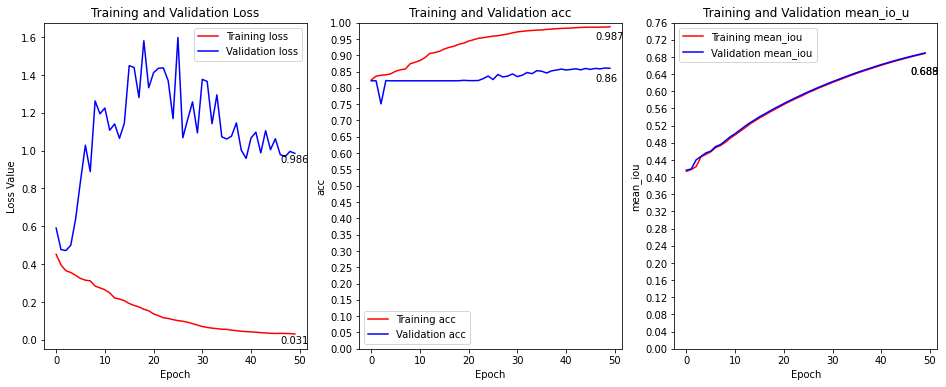


Model 2


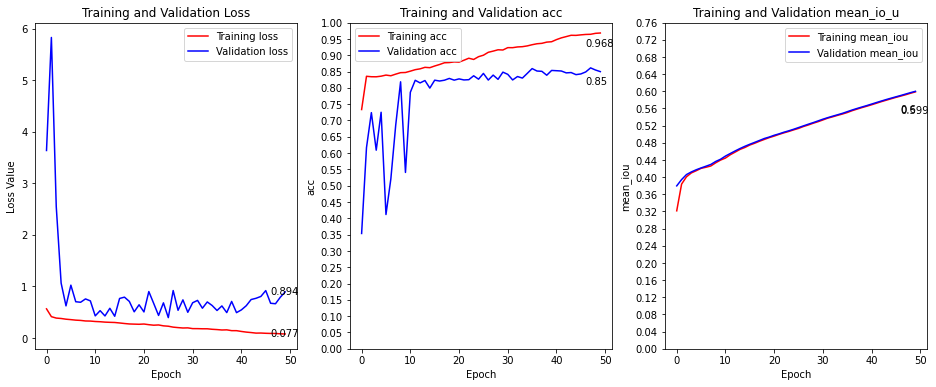


Model 3


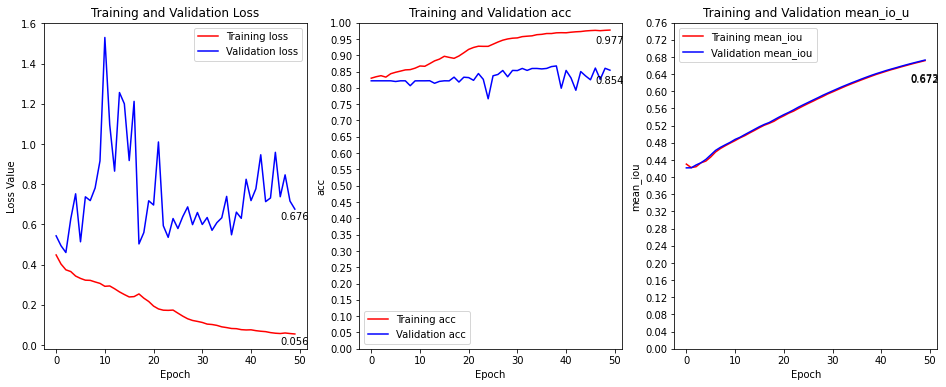


Model 4


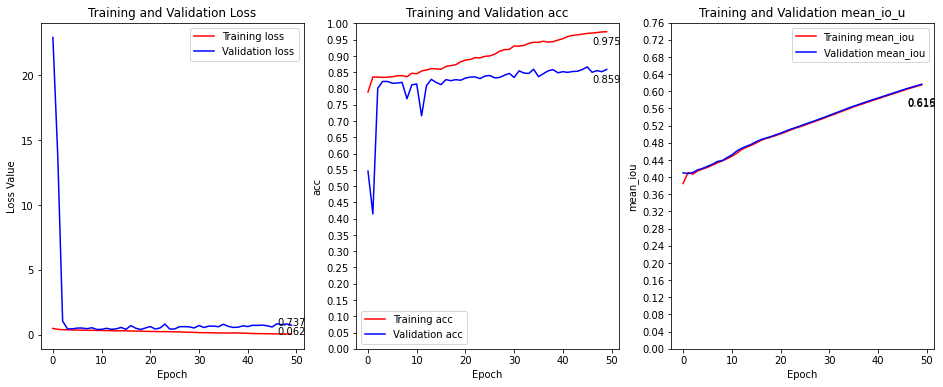


Model 5


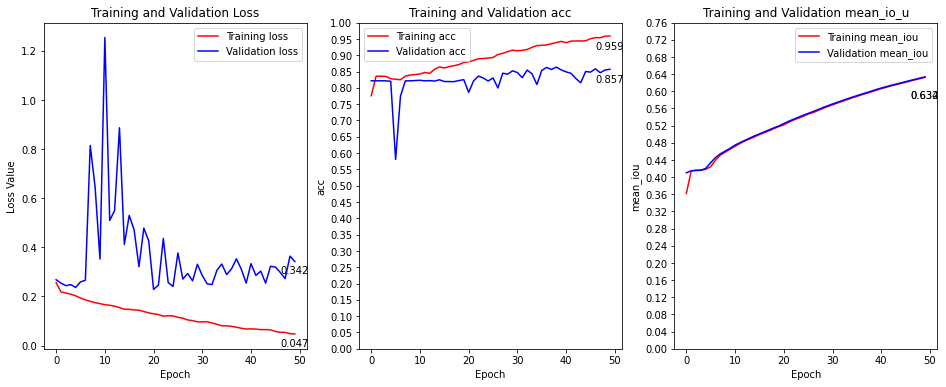


Model 6


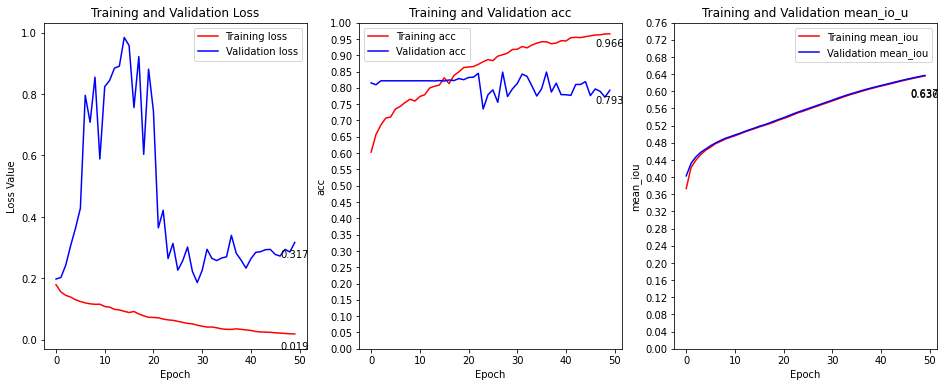

In [ ]:
for i in range(1,7,1):
    with open(f'/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model{i}_results.json') as f:
        history = json.load(f)
        print(f'Model {i}')
        plot_result(history)
        print()

# Testing

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Background_remover/modelcombined_04_0.238711.h5")

In [ ]:
def ploting(imgpath, maskpath):
  plt.figure(figsize=(12,4))
 
  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)/255
 
  plt.subplot(1,3,1)
  plt.title('Original')
  plt.imshow(im)
 
  im = im.reshape((1,)+im.shape)
  im.shape
 
  pred = model3.predict(im)
  
  p = pred.copy()
  p = p.reshape(p.shape[1:-1])
 
  p[np.where(p>.5)] = 1
  p[np.where(p<.5)] = 0
 
  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)
 
  im[:,:,0] = im[:,:,0]*p 
  im[:,:,0][np.where(p!=1)] = 247
  im[:,:,1] = im[:,:,1]*p 
  im[:,:,1][np.where(p!=1)] = 231
  im[:,:,2] = im[:,:,2]*p
  im[:,:,2][np.where(p!=1)] = 230
 
  plt.subplot(1,3,2)
  plt.imshow(im)
  
  if maskpath:
    plt.subplot(1,3,3)
    mask = io.imread(maskpath)
    plt.imshow(mask)
 
    plt.show()

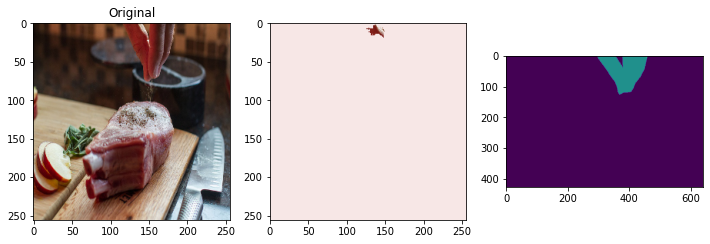

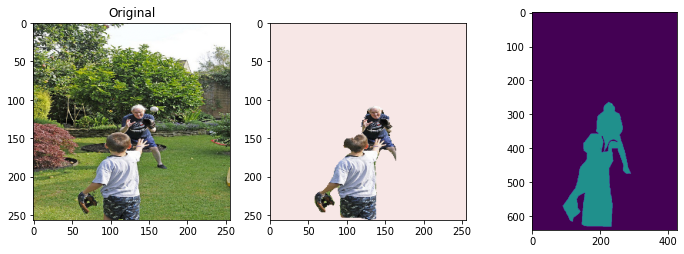

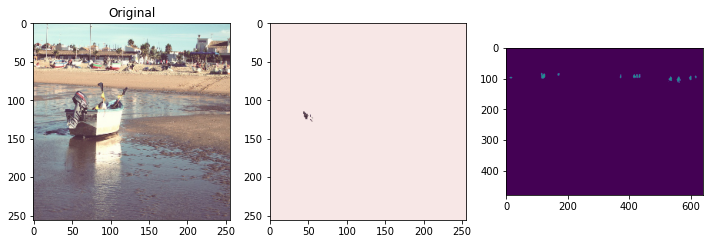

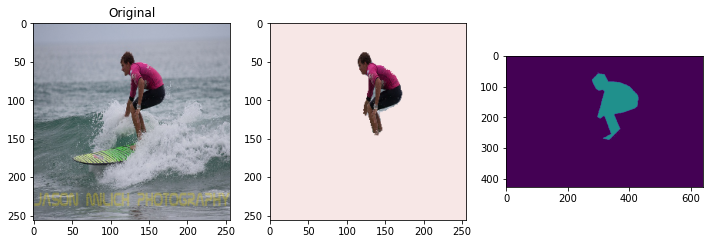

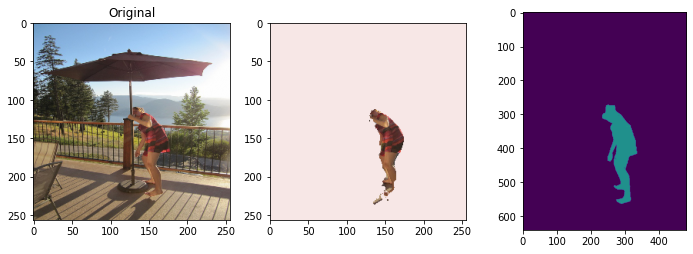

In [ ]:
n_images = 5
for i in np.random.randint(0,len(train_input_img_paths),n_images):
  ploting(train_input_img_paths[i], train_target_img_paths[i])

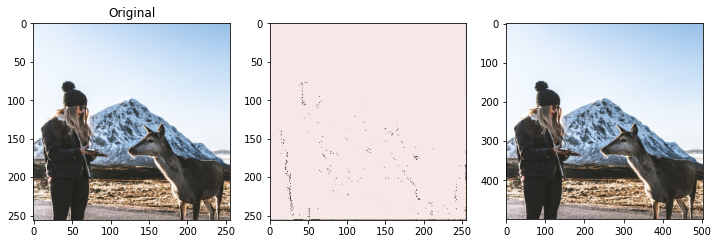

In [ ]:
ploting('https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/hibuddy.jpg','https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/hibuddy.jpg')

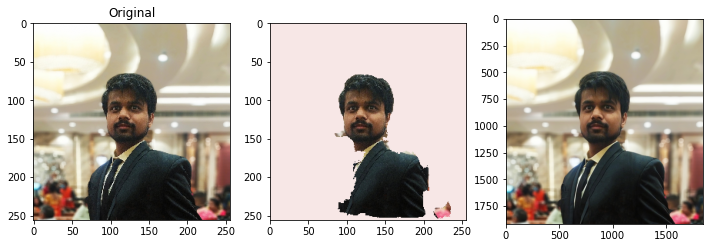

In [ ]:
ploting('/content/1613848099513.jpg','/content/1613848099513.jpg')

In [ ]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    threshold = 0.5
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > threshold, tf.int32)
    
    iou_metric.update_state(y_true_, y_pred_)
    
    return iou_metric.result()

In [ ]:
path = 'https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/hibuddy.jpg'

In [ ]:
im = io.imread(path)
im = cv2.resize(im,img_size)
im = np.array(im)/255
 
im = im.reshape((1,)+im.shape)
im.shape

(1, 256, 256, 3)

In [ ]:
pred = model3.predict(im)
pred.shape

(1, 256, 256, 1)

In [ ]:
pred1 = pred.copy()
pred1[:, 0:150, 150:250,:] = 1

In [ ]:
p = pred.reshape(pred.shape[1:-1])

In [ ]:
mean_iou(pred1, pred).numpy()

0.45642808

In [ ]:
p = np.append(pred,pred, axis = 0)
p.shape

(2, 256, 256, 1)

In [ ]:
mean_iou(p, p).numpy()

0.47162712

 
# Mean IOU
 
https://stackoverflow.com/questions/61146598/cant-reduce-loss-in-semantic-segmentationunet-and-mean-iou-isnt-improving-ei
 
https://stackoverflow.com/questions/59990587/tf-keras-metrics-meaniou-with-sigmoid-layer

In [ ]:
from sklearn.metrics import confusion_matrix 

In [ ]:
#IOU = true_positive / (true_positive + false_positive + false_negative)
#iou = true_positives / (sum_row + sum_col - true_positives))

def CalculateAndCompareIOU(y_true, y_pred):
    print('Confusion Matrix:', confusion_matrix(y_true.ravel(), y_pred.ravel()))

    tn, fp, fn, tp = confusion_matrix(y_true.ravel(), y_pred.ravel()).ravel()
    print('tn, fp, fn, tp:', tn, fp, fn, tp)

    IOU = tp/(tp + fp + fn)
    print('Calculated IOU:',IOU)

    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(y_true, y_pred)
 
    print('Tensorflow IOU:',m.result().numpy())
    

In [ ]:
x1 = np.array([[0, 0],
               [1, 0]])
y1 = np.array([[0, 0],
               [1, 0]])

x2 = np.array([[0, 0],
               [1, 0]])
y2 = np.array([[1, 1],
               [0, 1]])

print(x1.shape, x2.shape)

(2, 2) (2, 2)


In [ ]:
CalculateAndCompareIOU(x1, y1)

Confusion Matrix: [[3 0]
 [0 1]]
tn, fp, fn, tp: 3 0 0 1
Calculated IOU: 1.0
Tensorflow IOU: 1.0


In [ ]:
CalculateAndCompareIOU(x2,y2)

Confusion Matrix: [[0 3]
 [1 0]]
tn, fp, fn, tp: 0 3 1 0
Calculated IOU: 0.0
Tensorflow IOU: 0.0


1.0

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)

In [ ]:
m.update_state(np.array([0,1]),
               np.array([1,0]))
 
m.result().numpy()

0.0

In [ ]:
m.update_state(np.array([0,1]),
               np.array([0,1]))
 
 
m.result().numpy()

0.33333334

In [ ]:
'''
IOU = true_positive / (true_positive + false_positive + false_negative).

# cm = [[1, 1],
#        [1, 1]]
# sum_row = [2, 2], sum_col = [2, 2], true_positives = [1, 1]
# iou = true_positives / (sum_row + sum_col - true_positives))

# result = (1 / (2 + 2 - 1) + 1 / (2 + 2 - 1)) / 2 = 0.33
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()
'''

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes = 2)
def mean_iou(y_true, y_pred):
    th = 0.4
    y_true_ = tf.cast(y_true, tf.int32)
    y_pred_ = tf.cast(y_pred > th, tf.int32)
    
    m.update_state(y_true_,y_pred_)
    
    return m.result().numpy()

In [ ]:
a = np.array([0, 0, 1, 1])
b = np.array([0, 0, 0, 1])
 
mean_iou(a,b)

0.5833334

In [ ]:
CalculateAndCompareIOU(a,b)

Confusion Matrix: [[2 0]
 [1 1]]
tn, fp, fn, tp: 2 0 1 1
Calculated IOU: 0.5
Tensorflow IOU: 0.5833334


In [ ]:
tf.cast(np.array([0, 0.51, 1, 1]) > .5, tf.int32).numpy()

array([0, 1, 1, 1], dtype=int32)

# The End